In [2]:
# CLIP encodes the image once, hence each layer has one attention map
# LLaMA encodes the sentence multiple times, and with only queries for generation,
# hence the latter attention maps of the same layer
# have the shape [B, H, 1, KV_LEN]
# Hence we create once attention matrix for one layer by concating everything
# `rollout(...)` copied over from 
# https://github.com/sayakpaul/vit-explain/blob/4f92628ed4b5109f43febd2976f688e585baa44b/vit_rollout.py
# Thanks @sayakpaul!

import torch
import numpy as np
from torchvision.utils import save_image
import cv2
from torch.nn import functional as F



def calculate_modality_indices(inputs_emb_modalities, bsz=1, seq_len=None):
    # bsz, num_heads, q_len, kv_len = attn_weights.size()
    
    if seq_len == None:
        raise ValueError("`seq_len` should be a positive integer, found None.")
    
    image_attn_mask = torch.zeros(bsz, seq_len)
    video_attn_mask = torch.zeros(bsz, seq_len)
    text_attn_mask = torch.zeros(bsz, seq_len)
    
    mask_map = dict(
        text=text_attn_mask,
        image=image_attn_mask,
        video=video_attn_mask
    )
    
    modalities_buffer = inputs_emb_modalities
    # List[List[Dict['modality': num_tokens]]]
    
    for example_idx in range(len(modalities_buffer)):
        example_buffer = modalities_buffer[example_idx]
        running_tok_idx = 0
        for chunk_idx in range(len(example_buffer)):
            chunk_modality = list(example_buffer[chunk_idx].keys())[0]
            chunk_tokens = list(example_buffer[chunk_idx].values())[0]
            mask_map[chunk_modality][example_idx, running_tok_idx : running_tok_idx + chunk_tokens] = 1
            running_tok_idx += chunk_tokens
    
    
    return image_attn_mask, video_attn_mask, text_attn_mask

def combine_attention(layer_attn_list):
    final_attn = list()
    max_len = layer_attn_list[-1].shape[-1]
    
    num_generated_tokens = 0
    
    for attn in layer_attn_list:
        if attn.shape[-2] == 1:
            num_generated_tokens += 1
        curr_kv_len = attn.shape[-1]
        final_attn.append(F.pad(attn, (0, max_len - curr_kv_len, 0, 0, 0, 0, 0, 0)))
    
    # print(num_generated_tokens)
    return torch.cat(final_attn, dim=-2), num_generated_tokens



def combine_all_layers(attns):
    for key in attns.keys():
        if key.startswith("llama"):
            attns[key] = combine_attention(attns[key])
    return attns


def rollout(attentions, discard_ratio=0.8, head_fusion="min"):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

In [3]:
# attns = torch.load("debug.pt")
# modalities = torch.load("debug_modalities.pt")
# for layer_idx in range(1):
#     combined_attn = combine_attention(attns[f"llama_attn_{layer_idx}"])
#     img_mask, vid_mask, text_mask = calculate_modality_indices(modalities, seq_len=combined_attn.shape[-1])
#     pooled_combined_attn = torch.mean(combined_attn, dim=1)
    
    
    

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os

tensor(0.)
tensor(0.0431)
tensor(0.)
tensor(0.1255)
tensor(0.)
tensor(0.0902)
tensor(0.)
tensor(0.0431)
tensor(0.)
tensor(0.0745)
tensor(0.)
tensor(0.0706)
tensor(0.)
tensor(0.0588)
tensor(0.)
tensor(0.0431)
tensor(0.)
tensor(0.0627)
tensor(0.)
tensor(0.1020)
tensor(0.)
tensor(0.0824)
tensor(0.)
tensor(0.0431)
tensor(0.)
tensor(0.0627)
tensor(0.)
tensor(0.1059)
tensor(0.)
tensor(0.0745)
tensor(0.)
tensor(0.0784)
tensor(0.)
tensor(0.1255)
tensor(0.)
tensor(0.1216)
tensor(0.)
tensor(0.0784)
tensor(0.)
tensor(0.0745)
tensor(0.)
tensor(0.1294)
tensor(0.)
tensor(0.0706)
tensor(0.)
tensor(0.1176)
tensor(0.)
tensor(0.1373)
tensor(0.)
tensor(0.0471)
tensor(0.)
tensor(0.0588)
tensor(0.)
tensor(0.1098)
tensor(0.)
tensor(0.1059)
tensor(0.)
tensor(0.0902)
tensor(0.)
tensor(0.0824)
tensor(0.)
tensor(0.1020)
tensor(0.)
tensor(0.1765)


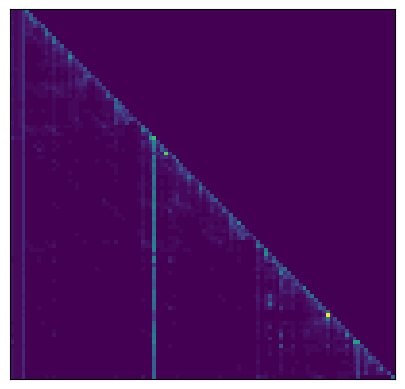

In [10]:
attns = torch.load("video_vanilla_debug.pt")
modalities = torch.load("video_vanilla_debug_modalities.pt")
for layer_idx in range(32):
    combined_attn, num_generated_tokens = combine_attention(attns[f"llama_attn_{layer_idx}"])
    img_mask, vid_mask, text_mask = calculate_modality_indices(modalities, seq_len=combined_attn.shape[-1])
    pooled_combined_attn = torch.mean(combined_attn, dim=1)
    
    img_attn_wrt_gen_tokens = pooled_combined_attn[..., -num_generated_tokens:, vid_mask[0].to(torch.bool)].cpu()
    text_attn_wrt_gen_tokens = pooled_combined_attn[..., -num_generated_tokens:, -num_generated_tokens:].cpu()

    num_tokens = 4
    step = 2048 // num_tokens
    avg_img_attn = torch.nn.functional.avg_pool1d(img_attn_wrt_gen_tokens.float(), kernel_size=step, stride=step) * (256 / num_tokens)
    

    
    pooled_combined_attn = torch.concat([avg_img_attn, text_attn_wrt_gen_tokens], dim=-1)
    pooled_combined_attn = pooled_combined_attn.permute(1,2,0).cpu().numpy()
    
    score_map = torch.tensor(np.uint8(255 * pooled_combined_attn)).to(torch.float32).permute(2, 0, 1) / 255.
    print(torch.min(score_map))
    print(torch.max(score_map))
    # plt.plot(score_map.numpy()[0])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(score_map.permute(1,2 ,0).numpy(), cmap='viridis', interpolation='nearest')
    os.makedirs("vanilla/video/", exist_ok=True)
    plt.savefig(f"vanilla/video/vanilla_video_attn_wrt_gen_tokens_{layer_idx}.png",  bbox_inches='tight', pad_inches=0.0)
    # cv2.imwrite(score_map, )
    # save_image(score_map, f"img_attn_wrt_gen_tokens_{layer_idx}.jpg")
    
    
    # print(img_attn.shape)
    # num_tokens = 8 # MUST DIVIDE 256
    # step = 256 // num_tokens
    # # avg_img_attn = torch.nn.functional.avg_pool1d(img_attn, kernel_size=step, stride=step)
    # avg_img_attn = torch.zeros(1, img_attn.shape[-2], num_tokens)
    # for idx in range(256):
    #     avg_img_attn[..., idx % num_tokens] += img_attn[..., idx]
    # print(text_attn.shape)
    # avg_img_attn = avg_img_attn[..., img_mask[0].to(torch.bool), :].permute(0,2,1)
    # avg_img_attn = torch.nn.functional.max_pool1d(img_attn, kernel_size=step, stride=step).permute(0, 2, 1)
    
    # print(avg_img_attn.shape)
        
    

In [ ]:
pooled_combined_attn[0][0]

In [ ]:
torch.sum(pooled_combined_attn, dim=2)